In [1]:
%load_ext nb_black
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict


# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


# Models

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import OneClassSVM


# Evaluation

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    make_scorer,
)
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.model_selection import PredefinedSplit, ShuffleSplit


import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


<IPython.core.display.Javascript object>


## load data

look at number of observations and columns

In [2]:
data = pd.read_csv("mtsamples.csv")

print(data.shape)
print(data.columns)

(4999, 6)
Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


<IPython.core.display.Javascript object>

In [3]:
data[data["medical_specialty"] == " Dentistry"]

data = data.sort_values("medical_specialty")

<IPython.core.display.Javascript object>

In [4]:
print(len(data[data["medical_specialty"] == " Dentistry"]))

27


<IPython.core.display.Javascript object>

delete all unnecessary columns and all NA observations. We are only interested in the text and the labels

In [5]:
new_list = list(data[data["medical_specialty"] == " Dentistry"]["transcription"])

print(len(new_list))

27


<IPython.core.display.Javascript object>

In [6]:
data["dentistry"] = data["transcription"].map(lambda x: 1 if x in new_list else -1)

<IPython.core.display.Javascript object>

In [7]:
len(data[data["dentistry"] == 1])

60

<IPython.core.display.Javascript object>

In [8]:
data = data.drop_duplicates(
    subset="transcription"
)  # , 'medical_specialty'], keep="first")

print(data.shape)
data = data.drop(data[data["transcription"].isna()].index)

print(data.shape)

(2358, 7)
(2357, 7)


<IPython.core.display.Javascript object>

In [9]:
sum(data["dentistry"] == 1)

27

<IPython.core.display.Javascript object>

In [10]:
data = data[["dentistry", "transcription", "medical_specialty"]]

<IPython.core.display.Javascript object>

In [11]:
data["medical_specialty"].value_counts()


 Consult - History and Phy.       444
 Cardiovascular / Pulmonary       370
 Orthopedic                       216
 Gastroenterology                 173
 Neurology                        139
 Surgery                          138
 Obstetrics / Gynecology          121
 Discharge Summary                 90
 ENT - Otolaryngology              70
 Neurosurgery                      66
 Ophthalmology                     63
 General Medicine                  52
 Hematology - Oncology             51
 Pain Management                   50
 Nephrology                        47
 Emergency Room Reports            30
 Dentistry                         24
 Cosmetic / Plastic Surgery        23
 SOAP / Chart / Progress Notes     22
 Dermatology                       21
 Bariatrics                        18
 Podiatry                          18
 Letters                           16
 Radiology                         15
 Chiropractic                      14
 Endocrinology                     12
 Psychiatry 

<IPython.core.display.Javascript object>

In [12]:
data["medical_specialty"].value_counts().count()

37

<IPython.core.display.Javascript object>

### Create plots and analyze the total number of words and the average sentence length

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r"\w+")
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

1131448 words total, with a vocabulary size of 28581
Max sentence length is 3114


<IPython.core.display.Javascript object>

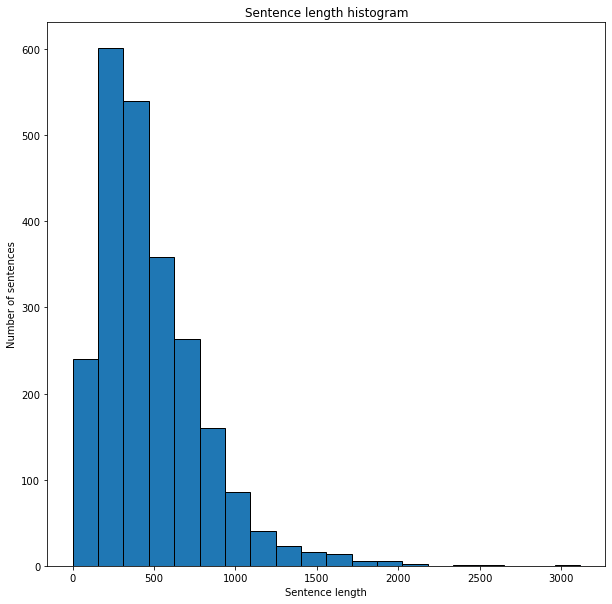

<IPython.core.display.Javascript object>

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.title("Sentence length histogram")
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.hist(sentence_lengths, edgecolor="black", bins=20)
plt.show()

## Load the scientific papers

In [15]:
papers = pd.read_csv("dentistry_teeth.txt")

papers.head()

len(papers)

602

<IPython.core.display.Javascript object>

### Create plots and analyze the total number of words and the average sentence length for the scientific papers

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r"\w+")
papers["tokens"] = papers["text"].apply(tokenizer.tokenize)

all_words_papers = [word for tokens in papers["tokens"] for word in tokens]
sentence_lengths_papers = [len(tokens) for tokens in papers["tokens"]]
VOCAB_PAPERS = sorted(list(set(all_words_papers)))
print(
    "%s words total, with a vocabulary size of %s"
    % (len(all_words_papers), len(VOCAB_PAPERS))
)
print("Max sentence length is %s" % max(sentence_lengths_papers))

87044 words total, with a vocabulary size of 7877
Max sentence length is 322


<IPython.core.display.Javascript object>

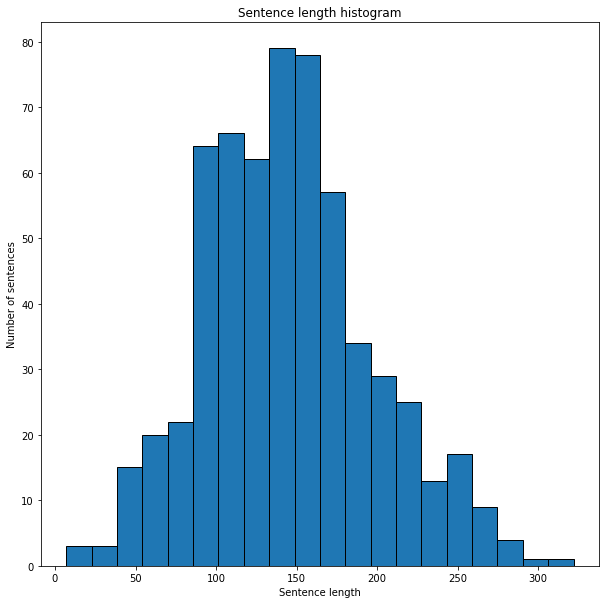

<IPython.core.display.Javascript object>

In [17]:
fig = plt.figure(figsize=(10, 10))
plt.title("Sentence length histogram")
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.hist(sentence_lengths_papers, edgecolor="black", bins=20)
plt.show()

## Prepare data for accuracy by marking all data out of category "Dentistry"

In [18]:
data[data["dentistry"] == 1]


try:
    data = data.reset_index()
except:
    pass

try:
    data = data.drop("level_0", 1)
except:
    pass

try:
    data = data.drop("index", 1)
except:
    pass

print(data)

      dentistry                                      transcription  \
0            -1  SUBJECTIVE:,  This 23-year-old white female pr...   
1            -1  SUBJECTIVE: , This is a 42-year-old white fema...   
2            -1  ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...   
3            -1  HISTORY:,  I had the pleasure of meeting and e...   
4            -1  HISTORY:,  A 55-year-old female presents self-...   
...         ...                                                ...   
2352         -1  PREOPERATIVE DIAGNOSES:,1.  Benign prostatic h...   
2353         -1  PREOPERATIVE DIAGNOSIS: , Traumatic injury to ...   
2354         -1  PREOPERATIVE DIAGNOSES:,1.  Urinary retention....   
2355         -1  PREOPERATIVE DIAGNOSIS:,  Status post polytrau...   
2356         -1  PREOPERATIVE DIAGNOSIS: , Necrotizing infectio...   

          medical_specialty                                             tokens  
0      Allergy / Immunology  [SUBJECTIVE, This, 23, year, old, white, femal...

<IPython.core.display.Javascript object>

## Paper cleaning

We see a few papers in the plot with very little words which seems unlikely. 

In [19]:
pd.set_option("display.max_rows", 1200)
print(papers)

                                                  text  \
0     A triangular/square-wave generator with curre...   
1     A novel ultracompact 2/spl times/2 wavelength...   
2     This paper investigates micro-parts feeding u...   
3     We propose an EMG-based mouse control method ...   
4     Current fabrication of invisible tooth aligne...   
5     For low cost wireless data acquisition provid...   
6     A function generation method of tooth-layer p...   
7     For the reduction of the cogging torque of pe...   
8     Since PCA-based teeth-image personal identifi...   
9     In the application of the fault diagnosis, pr...   
10    Gears form a critical part of many electromec...   
11    The paper presents key elements of an origina...   
12    Continuing the paper (Colosi et al., 2006), "...   
13    This paper constitutes the first stage of a m...   
14    Artificial neural network (ANN), with its hig...   
15    In attempts to improve the quality of life (Q...   
16    The goal

<IPython.core.display.Javascript object>

In [20]:
papers = papers.drop_duplicates(subset=["text"])

print(papers)

                                                  text  \
0     A triangular/square-wave generator with curre...   
1     A novel ultracompact 2/spl times/2 wavelength...   
2     This paper investigates micro-parts feeding u...   
3     We propose an EMG-based mouse control method ...   
4     Current fabrication of invisible tooth aligne...   
5     For low cost wireless data acquisition provid...   
6     A function generation method of tooth-layer p...   
7     For the reduction of the cogging torque of pe...   
8     Since PCA-based teeth-image personal identifi...   
9     In the application of the fault diagnosis, pr...   
10    Gears form a critical part of many electromec...   
11    The paper presents key elements of an origina...   
12    Continuing the paper (Colosi et al., 2006), "...   
13    This paper constitutes the first stage of a m...   
14    Artificial neural network (ANN), with its hig...   
15    In attempts to improve the quality of life (Q...   
16    The goal

<IPython.core.display.Javascript object>

Remove all papers that have mistakes in them and are 

In [21]:
mistake = papers["text"].iloc[77]

papers = papers[papers["text"] != mistake]

print(len(papers))


597


<IPython.core.display.Javascript object>

## Basic text preprocessing

In [22]:
# Text preparation

def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    NUMBERS = re.compile('\d+')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)
    text = NUMBERS.sub('', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, 'v') for w in text])

def basic_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    
    try:
        df_temp = df_temp.rename(index = str, columns = {'transcription': 'text'})
    except: 
        pass
    
    
    df_temp.loc[:, 'text'] = [text_prepare(x) for x in df_temp['text'].values]
    df_temp["text"]= [item for item in df_temp['text'] if not item.isdigit()]
    

    
    try:
        le = LabelEncoder()
        le.fit(df_temp['medical_specialty'])
        df_temp.loc[:, 'class_label'] = le.transform(df_temp['medical_specialty'])
    except:
        pass
    
    tokenizer = RegexpTokenizer(r'\w+')

    df_temp["tokens"] = df_temp["text"].apply(tokenizer.tokenize)
    df_temp["lemma"] = df_temp["tokens"].apply(lemmatize_text)
    df_temp["tokens"] = df_temp["lemma"].apply(tokenizer.tokenize)
    
    
    return df_temp



<IPython.core.display.Javascript object>

## Preprocess the text to perfom topic modelling as Data exploration

In [23]:
df_processed = basic_preprocessing(data)
papers_processed = basic_preprocessing(papers)

<IPython.core.display.Javascript object>

# Vectorize words TF-IDF

In [24]:
def tfidf(data, papers, ngrams=2, labels=True):

    df_temp = data.copy(deep=True)
    df_temp = basic_preprocessing(df_temp)
    
    papers_temp = papers.copy(deep=True)
    papers_temp = basic_preprocessing(papers_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    
    corpus = df_temp['lemma'].append(papers_temp['lemma'])
    tfidf_vectorizer.fit(corpus)

    list_corpus = corpus.tolist()
    list_labels = df_temp["class_label"].tolist()
    
    data_corpus = df_temp["lemma"].tolist()
    paper_corpus = papers_temp["lemma"].tolist()

    data = tfidf_vectorizer.transform(data_corpus)
    papers = tfidf_vectorizer.transform(paper_corpus)
    
    return data, list_labels, papers


<IPython.core.display.Javascript object>

# Function that vectorizes word but uses 8000 max features in TF-IDF

In [25]:
def tfidf_features(data, papers, ngrams=2, labels=True):

    df_temp = data.copy(deep=True)
    df_temp = basic_preprocessing(df_temp)
    
    papers_temp = papers.copy(deep=True)
    papers_temp = basic_preprocessing(papers_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams), max_features=8000)
    
    corpus = df_temp['lemma'].append(papers_temp['lemma'])
    tfidf_vectorizer.fit(corpus)

    list_corpus = corpus.tolist()
    list_labels = df_temp["class_label"].tolist()
    
    data_corpus = df_temp["lemma"].tolist()
    paper_corpus = papers_temp["lemma"].tolist()

    data = tfidf_vectorizer.transform(data_corpus)
    papers = tfidf_vectorizer.transform(paper_corpus)
    
    return data, list_labels, papers


<IPython.core.display.Javascript object>

# vectorize two times, once with max featuers for naive bayes, SVM and once using ALL featuers

In [26]:
data_tfidf, labels, papers_tfidf = tfidf(data, papers)
data_tfidf_features, labels_featuers, papers_tfidf_features = tfidf_features(
    data, papers
)

<IPython.core.display.Javascript object>

In [27]:
print(data_tfidf.shape, data_tfidf_features.shape)

(2357, 385192) (2357, 8000)


<IPython.core.display.Javascript object>

# Topic Model on complete data set to see if category Dentistry can be defined

In [28]:
dictionary_overall = gensim.corpora.Dictionary(df_processed["tokens"])
dictionary_overall.filter_extremes(no_below=15, no_above=0.5)

<IPython.core.display.Javascript object>

In [29]:
bow_corpus_overall = [dictionary_overall.doc2bow(doc) for doc in df_processed["tokens"]]

<IPython.core.display.Javascript object>

In [30]:
lda_model_data = gensim.models.LdaMulticore(
    bow_corpus_overall,
    num_topics=10,
    passes=10,
    id2word=dictionary_overall,
    random_state=101,
)
for idx, topic in lda_model_data.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.010*"mass" + 0.009*"bladder" + 0.009*"lobe" + 0.009*"cm" + 0.008*"procedure" + 0.008*"place" + 0.008*"chest" + 0.007*"x" + 0.007*"upper" + 0.007*"renal"
Topic: 1 Word: 0.019*"history" + 0.011*"mg" + 0.009*"normal" + 0.008*"pain" + 0.006*"deny" + 0.006*"blood" + 0.006*"present" + 0.005*"also" + 0.005*"time" + 0.005*"show"
Topic: 2 Word: 0.024*"eye" + 0.016*"normal" + 0.010*"anterior" + 0.009*"chamber" + 0.009*"ear" + 0.008*"without" + 0.008*"note" + 0.008*"negative" + 0.007*"lens" + 0.007*"clear"
Topic: 3 Word: 0.019*"place" + 0.014*"procedure" + 0.014*"suture" + 0.010*"incision" + 0.010*"skin" + 0.009*"remove" + 0.009*"room" + 0.008*"close" + 0.007*"diagnosis" + 0.007*"fashion"
Topic: 4 Word: 0.011*"pain" + 0.010*"time" + 0.009*"history" + 0.008*"report" + 0.008*"also" + 0.007*"state" + 0.006*"dr" + 0.006*"would" + 0.005*"day" + 0.005*"see"
Topic: 5 Word: 0.017*"place" + 0.007*"incision" + 0.007*"remove" + 0.007*"take" + 0.007*"perform" + 0.007*"position" + 0.007*"tiss

<IPython.core.display.Javascript object>

# Visualize the topic Models output

In [31]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

visualization_overall = pyLDAvis.gensim.prepare(
    lda_model_data, bow_corpus_overall, dictionary_overall
)

pyLDAvis.display(visualization_overall)

<IPython.core.display.Javascript object>

# Create examplery wordclouds

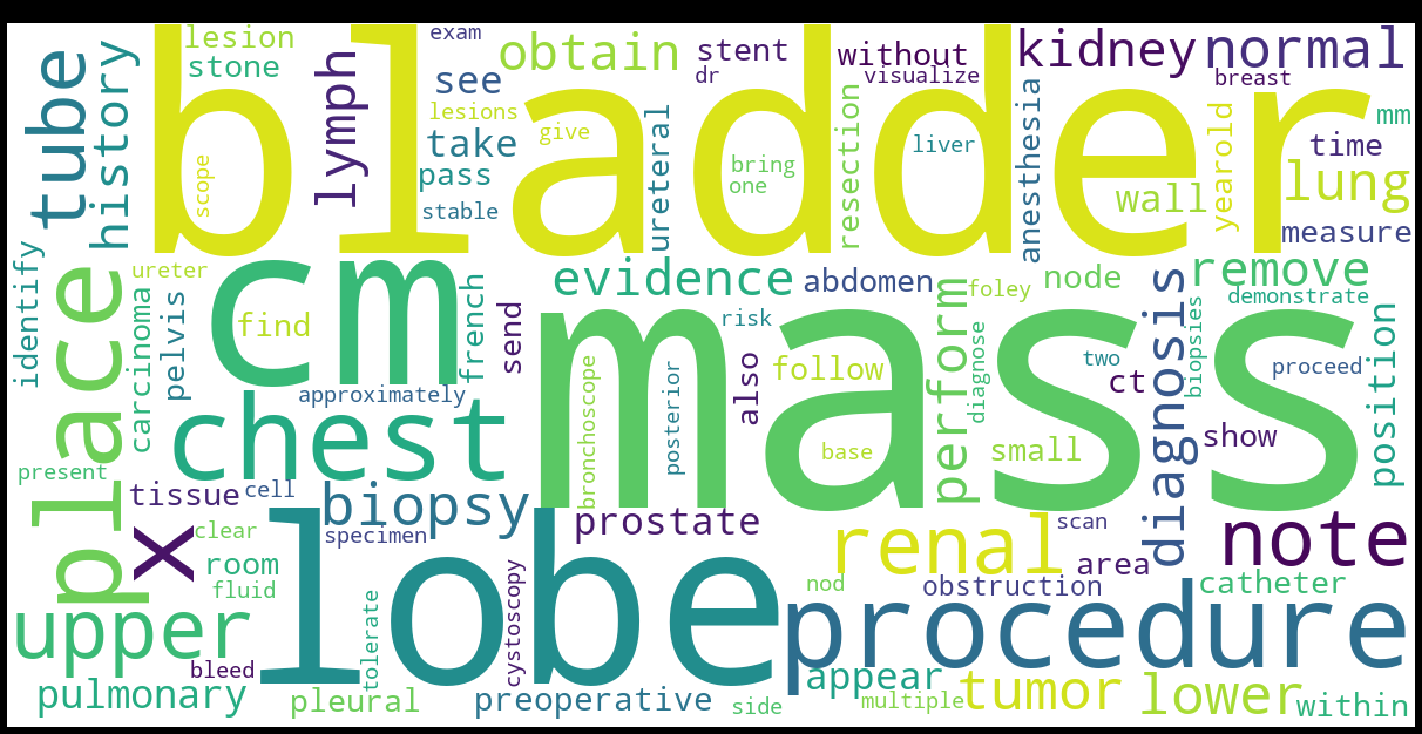

<IPython.core.display.Javascript object>

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


plt.figure(figsize=(20, 10), facecolor="k")
plt.imshow(
    WordCloud(width=1200, height=600, background_color="white").fit_words(
        dict(lda_model_data.show_topic(0, 100))
    )
)
plt.axis("off")
plt.title("medical_data_Model #" + "topic #0")
plt.tight_layout(pad=0)
plt.savefig("wordcloud_medical_data_topic#0_1" + ".png")

### Also analyze the scraped papers to make sure the scraping was successfull

In [33]:
dictionary_paper = gensim.corpora.Dictionary(papers_processed["tokens"])
dictionary_paper.filter_extremes(no_below=2, no_above=0.9)

<IPython.core.display.Javascript object>

In [34]:
bow_corpus_paper = [dictionary_paper.doc2bow(doc) for doc in papers_processed["tokens"]]

<IPython.core.display.Javascript object>

In [35]:
lda_model_paper = gensim.models.LdaMulticore(
    bow_corpus_paper,
    num_topics=3,
    id2word=dictionary_paper,
    random_state=101,
    passes=10,
)
for idx, topic in lda_model_paper.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.016*"tooth" + 0.015*"teeth" + 0.014*"use" + 0.008*"result" + 0.007*"surface" + 0.007*"image" + 0.006*"method" + 0.006*"study" + 0.006*"design" + 0.005*"group"
Topic: 1 Word: 0.021*"tooth" + 0.015*"use" + 0.013*"gear" + 0.013*"model" + 0.013*"dental" + 0.012*"teeth" + 0.010*"system" + 0.009*"method" + 0.009*"image" + 0.008*"result"
Topic: 2 Word: 0.025*"machine" + 0.017*"torque" + 0.014*"wind" + 0.012*"stator" + 0.012*"paper" + 0.012*"design" + 0.011*"motor" + 0.011*"teeth" + 0.011*"method" + 0.010*"propose"


<IPython.core.display.Javascript object>

In [36]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

visualization_paper = pyLDAvis.gensim.prepare(
    lda_model_paper, bow_corpus_paper, dictionary_paper
)

pyLDAvis.display(visualization_paper)

<IPython.core.display.Javascript object>

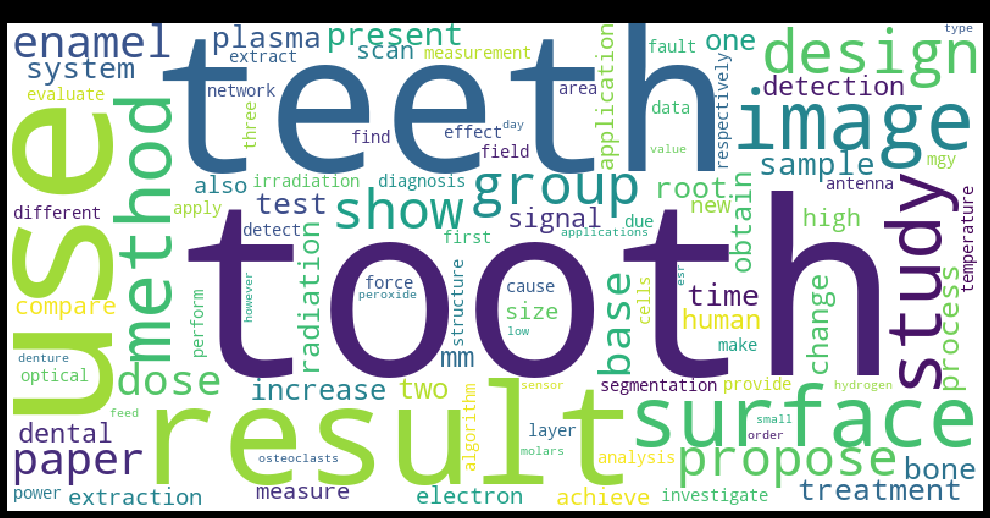

<IPython.core.display.Javascript object>

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


plt.figure(figsize=(14, 7), facecolor="k")
plt.imshow(
    WordCloud(width=800, height=400, background_color="white").fit_words(
        dict(lda_model_paper.show_topic(0, 100))
    )
)
plt.axis("off")
plt.title("dentistry_paper_Model #" + "topic #0")
plt.tight_layout(pad=0)
plt.savefig("wordcloud_dentistry_paper topic #0" + ".png")

## Check other "simpler" methods as a keyword search

In [38]:
def filter_by_phrases(row_text, phrases, number_of_matches):
    """Filters DataFrame Rows by number of phrases"""
    matches = 0
    for phrase in phrases:
        is_match = phrase in row_text
        matches += int(is_match)
    return matches >= number_of_matches

<IPython.core.display.Javascript object>

### The keywords are obtained by asking two practicing dentists for relevant keywords they would use to identify the topic of dentistry

In [39]:
keyword_list = [
    "dentistry",
    "dentist",
    "tooth",
    "teeth",
    "periodontology",
    "endodontics",
    "orthodontics",
    "dental surgery",
    "prosthetics",
    "tooth preservation",
    "pediatric dentistry",
    "periodontics",
    "alveolar",
    "maxilla",
    "mandible",
    "premolar",
    "molar",
    "incisive",
    "amalgam",
    "filling composite",
    "dental prosthesis",
    "milk tooth",
    "inlay",
    "crown",
    "dental alloy",
    "ceramic restoration",
    "enamel",
    "dentine",
    "pulp",
    "dental",
]


dentistry_keywords = df_processed[
    df_processed["lemma"].apply(lambda row: filter_by_phrases(row, keyword_list, 1))
]


print(len(dentistry_keywords))
print(dentistry_keywords["text"])

214
6       history yearold male presents today selfreferr...
7       clothing body clad light green hospital gown i...
8       summary clinical history patient yearold afric...
10      anatomical summary sharp force wound neck left...
11      external examination summarythe body presented...
12      external examination body inch pound white fem...
13      external examination autopsy begun may body pr...
14      final diagnosis ligature strangulationa circum...
65      clinical history probable right upper lobe lun...
95      chief complaint year old female presents today...
143     history patient monthold presented today supra...
147     history pleasure meeting evaluating patient to...
159     history present illness kindly asked see patie...
172     spirometry spirometry reveals fvc adequatefev ...
173     history yearold retailer presents acute shortn...
176     spirometry spirometry reveals fvc adequatefev ...
179     preoperativepostoperative diagnoses severe tra...
184     ad

<IPython.core.display.Javascript object>

### We can conclude that neither lda topic modelling nor simple keyword searches can adequately find the dentistry data of interest

Topic modelling fails when it compes to unbalanced datasets, as the underrepresented topic cannot be captured. Keyword searches are susceptible to individual errors or views and thus often generally unsuited, as the simple missing of important keywords can lead to completely different results

### For visual exploration of the problem, the tf-idf vectors are plotted with the help of PCA

#### The two dimensional and three dimensional plots show the craped papers in red, and 2000 of the medical data in blue.


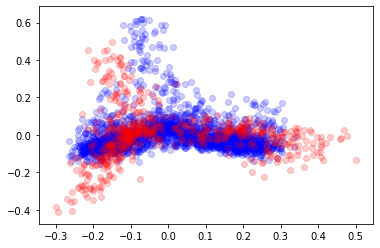

<IPython.core.display.Javascript object>

In [40]:
from sklearn.decomposition import PCA

x = data_tfidf_features[0:2500].todense()
pca = PCA(n_components=2).fit(x)

data2D = pca.transform(x)
plt.scatter(data2D[:, 0], data2D[:, 1], color="blue", alpha=0.2)

y = papers_tfidf_features.todense()
pca = PCA(n_components=2).fit(y)
Data2D_papers = pca.transform(y)

plt.scatter(Data2D_papers[:, 0], Data2D_papers[:, 1], color="red", alpha=0.2)

plt.show()

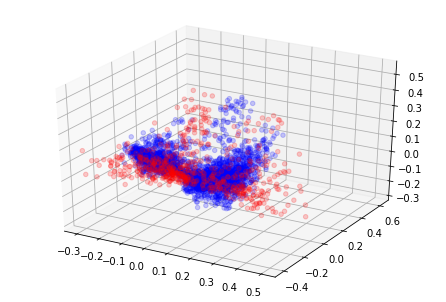

<IPython.core.display.Javascript object>

In [41]:
from mpl_toolkits.mplot3d import Axes3D

x = data_tfidf_features[0:2500].todense()
pca = PCA(n_components=3).fit(x)
data2D = pca.transform(x)

y = papers_tfidf_features.todense()
pca = PCA(n_components=3).fit(y)
Data2D_papers = pca.transform(y)

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(Data2D_papers[:,0], Data2D_papers[:,1], Data2D_papers[:,2], color="red", alpha=0.2)
ax.scatter(data2D[:,0], data2D[:,1], data2D[:,2], color="blue", alpha=0.2)
plt.show()


# One class SVM training and classification function

## Only analyze classifiers that predict at least 85% of the training data and between 20-100 (absolute) of the target data as positive


In [42]:
from sklearn.metrics import roc_auc_score


df = pd.DataFrame()


def classification(training, predicting, nus, quality_train, min_pred, max_pred):
    for i in nus:

        svm = OneClassSVM(nu=i, gamma="auto", kernel="rbf")
        # fit the model for each kernel
        clf = svm.fit(training)

        train = clf.predict(training)

        if sum(train[train == 1]) >= round(quality_train * len(train)):

            prediction = clf.predict(predicting)

            if (
                sum(prediction[prediction == 1])
                >= round(min_pred * (predicting.shape[0]))
            ) and (
                sum(prediction[prediction == 1])
                <= round(max_pred * (predicting.shape[0]))
            ):
                print(
                    "nu:",
                    str(i),
                    "data predicted:",
                    sum(prediction[prediction == 1]),
                    "training_data predicted:",
                    sum(train[train == 1]),
                )

                df["prediction: nu: ", str(i)] = prediction

    return df


def get_metrics(y_test, y_predicted):

    precision = precision_score(y_test, y_predicted, average="binary")

    recall = recall_score(y_test, y_predicted, average="binary")

    f1 = f1_score(y_test, y_predicted, average="binary")

    roc_score = roc_auc_score(y_test, y_predicted)

    accuracy = accuracy_score(y_test, y_predicted)

    return accuracy, precision, recall, f1, roc_score

<IPython.core.display.Javascript object>

In [43]:
nus = np.arange(0.001, 0.5, 0.001)

nus = np.round(nus, 5)

classifier = classification(
    training=papers_tfidf,
    predicting=data_tfidf,
    nus=nus,
    quality_train=0.85,
    min_pred=0.01,
    max_pred=0.1,
)

nu: 0.166 data predicted: 79 training_data predicted: 576
nu: 0.3 data predicted: 65 training_data predicted: 575


<IPython.core.display.Javascript object>

# Select the classifier

#### As we have three "classifiers" that fullfill the conditions of predicting at least 85% of the training data correctly and at least predicting 30 medical_specialties as dentistry - we select the classifier with the most predicted data, to find as much correctly classified medical_specialties as possible

#### Thus we select classifier number #3   for further inspection

## Further Inspection done by LDA topic modelling

In [44]:
sum(df_processed["dentistry"][classifier.index[df.iloc[:, 1] == 1].tolist()] == 1)

22

<IPython.core.display.Javascript object>

In [45]:
dictionary = gensim.corpora.Dictionary(
    df_processed["tokens"][classifier.index[classifier.iloc[:, 1] == 1].tolist()]
)
dictionary.filter_extremes(no_above=0.3)

<IPython.core.display.Javascript object>

In [46]:
bow_corpus = [
    dictionary.doc2bow(doc)
    for doc in df_processed["tokens"][
        classifier.index[classifier.iloc[:, 1] == 1].tolist()
    ]
]

<IPython.core.display.Javascript object>

# Analyze the classified data with LDA topic Model

In [47]:
lda_model_predicted = gensim.models.LdaMulticore(
    bow_corpus, num_topics=5, id2word=dictionary, random_state=101, passes=20
)
for idx, topic in lda_model_predicted.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.018*"abc" + 0.016*"tooth" + 0.015*"l" + 0.014*"caries" + 0.012*"spine" + 0.011*"dental" + 0.009*"physical" + 0.009*"lumbar" + 0.008*"lead" + 0.008*"mid"
Topic: 1 Word: 0.018*"cut" + 0.017*"knee" + 0.015*"component" + 0.014*"size" + 0.013*"tibial" + 0.012*"guide" + 0.012*"femoral" + 0.011*"proximal" + 0.011*"cement" + 0.010*"tendon"
Topic: 2 Word: 0.027*"joint" + 0.021*"proximal" + 0.020*"medial" + 0.020*"screw" + 0.019*"foot" + 0.019*"metatarsal" + 0.015*"blade" + 0.014*"toe" + 0.014*"next" + 0.013*"phalanx"
Topic: 3 Word: 0.022*"report" + 0.014*"deny" + 0.011*"work" + 0.011*"test" + 0.010*"problems" + 0.009*"mg" + 0.009*"evaluation" + 0.009*"change" + 0.008*"able" + 0.008*"disease"
Topic: 4 Word: 0.023*"tooth" + 0.017*"fracture" + 0.015*"mandible" + 0.012*"dental" + 0.012*"inch" + 0.011*"extraction" + 0.011*"space" + 0.010*"buccal" + 0.010*"system" + 0.009*"drain"


<IPython.core.display.Javascript object>

In [48]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

visualization = pyLDAvis.gensim.prepare(lda_model_predicted, bow_corpus, dictionary)

pyLDAvis.display(visualization)

<IPython.core.display.Javascript object>

In [49]:
pyLDAvis.save_html(visualization, "lda_model_predicted.html")

<IPython.core.display.Javascript object>

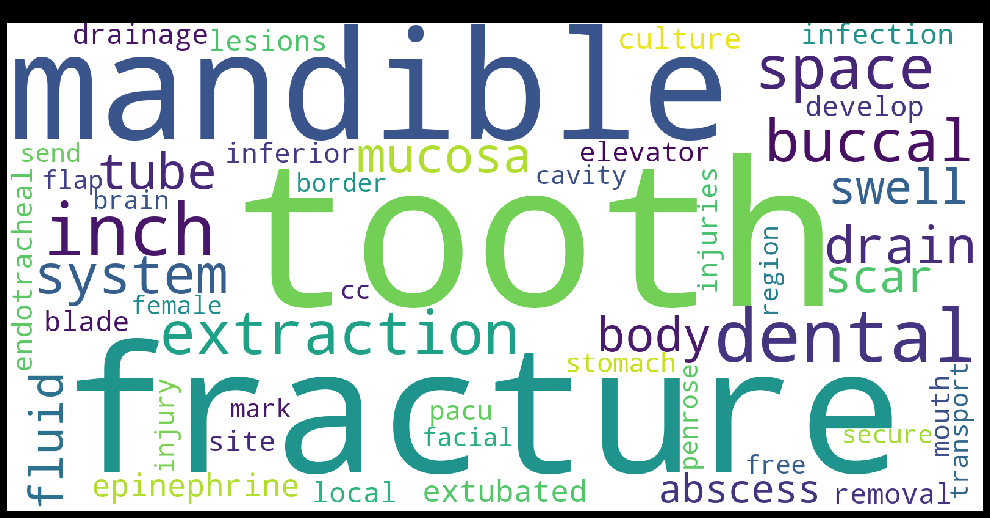

<IPython.core.display.Javascript object>

In [50]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


plt.figure(figsize=(14, 7), facecolor="k")
plt.imshow(
    WordCloud(width=1600, height=800, background_color="white").fit_words(
        dict(lda_model_predicted.show_topic(4, 50))
    )
)
plt.axis("off")
plt.title("dentistry_lda_model_predicted" + "topic #4")
plt.tight_layout(pad=0)
plt.savefig("wordcloud_dentistry_lda_model_predicted#4" + ".png")

## The LDAvis plot reveals, that two topis in particular capture the target topic of Dentistry

## We further analysis only those documents, that fullfil a certain prevalence threshhold to these two topics (in the LDAvis plot, topics #4, #5 in the output of the model topic #0 and topic #4)

### In the following, the topic distributions for each of the classified medical_specialties will be determined

In [51]:
def get_topics(lda_model, number_of_topics):
    train_vecs = []
    counter = 0

    for i in range(len(df_processed["tokens"][df.index[df.iloc[:, 1] == 1].tolist()])):

        # calculate the topic distribution for every tweet in test set
        top_topics = lda_model.get_document_topics(
            bow_corpus[i], minimum_probability=0.0
        )
        # get the distribution values for all topics
        topic_vec = [top_topics[i][1] for i in range(number_of_topics)]
        # include length of tweet as covariate, too
        # topic_vec.extend([len(text['final_text'].iloc[i])])
        train_vecs.append(topic_vec)
        counter = counter + 1
    return train_vecs


x = get_topics(lda_model_predicted, 5)

<IPython.core.display.Javascript object>

In [52]:
predicted_data = pd.DataFrame(columns=["dentistry", "tokens", "lemma"])

predicted_data["dentistry"] = df_processed["dentistry"][
    classifier.index[classifier.iloc[:, 1] == 1].tolist()
]
predicted_data["tokens"] = df_processed["tokens"][classifier.index[classifier.iloc[:, 1] == 1].tolist()]
predicted_data["lemma"] = df_processed["lemma"][classifier.index[classifier.iloc[:, 1] == 1].tolist()]


<IPython.core.display.Javascript object>

### We analyze the data by conducting each data points most dominant topic, as well as, the distributional values for the identified 'bad' topic

In [53]:
predicted_data["dominant_topic"] = ""

predicted_data['good_topic_threshhold_topic1'] = ""

predicted_data['good_topic_threshhold_topic2'] = ""



for i in range(len(x)):
    predicted_data["dominant_topic"][i] = x[i].index(max(x[i]))
    
for i in range(len(x)):
    predicted_data["good_topic_threshhold_topic1"][i] = x[i][0]
    
for i in range(len(x)):
    predicted_data["good_topic_threshhold_topic2"][i] = x[i][4]
    


<IPython.core.display.Javascript object>

In [54]:
predicted_data

,dentistry,tokens,lemma,dominant_topic,good_topic_threshhold_topic1,good_topic_threshhold_topic2
7,-1,"[clothe, body, clothe, light, green, hospital,...",clothe body clothe light green hospital gown i...,4,0.0006256,0.997494
11,-1,"[external, examination, summarythe, body, pres...",external examination summarythe body present b...,4,0.00134413,0.994678
13,-1,"[external, examination, autopsy, begin, may, b...",external examination autopsy begin may body pr...,4,0.00112224,0.870873
72,-1,"[clinical, history, yearold, black, woman, his...",clinical history yearold black woman history h...,0,0.460445,0.00211423
74,-1,"[clinical, history, yearold, male, patient, pr...",clinical history yearold male patient previous...,3,0.00194512,0.00194124
149,-1,"[procedure, perform, insertion, vvir, permanen...",procedure perform insertion vvir permanent pac...,0,0.993475,0.00163662
212,-1,"[indication, study, elevate, cardiac, enzymes,...",indication study elevate cardiac enzymes fulln...,3,0.12396,0.00355983
413,-1,"[po, box, city, state, examinee, abcclaim, num...",po box city state examinee abcclaim number dat...,3,0.482987,0.000540795
415,-1,"[date, injury, october, date, examination, sep...",date injury october date examination september...,0,0.617169,0.000293024
417,-1,"[reason, referral, ms, yearold, africanamerica...",reason referral ms yearold africanamerican fem...,3,0.000552461,0.000547523


<IPython.core.display.Javascript object>

In [55]:

dominant_prediction = predicted_data[
    (predicted_data["dominant_topic"] == 0) | (predicted_data["dominant_topic"] == 4) ]
threshhold_prediction = predicted_data[(predicted_data["good_topic_threshhold_topic1"] > 0.4) | 
                                       (predicted_data["good_topic_threshhold_topic2"] > 0.4)
                                      ]


<IPython.core.display.Javascript object>

In [56]:
print(sum(dominant_prediction["dentistry"] == 1))
print(sum(threshhold_prediction["dentistry"] == 1))

print(len(dominant_prediction))
print(len(threshhold_prediction))

20
22
31
35


<IPython.core.display.Javascript object>

#### The accuracy of the predictions will not be extremely well, but way better than any other unsupervised method.

With the dominant topic classification we were able to correctly predict 21 of the 27 dentistry medical_specialties out of the dataset, thus roughly recognizing 78% of the data of interest. The threshhold model recognized 22 of the dentistry medical_specialties, thus correctly recognizing 81% of the dentistry data.

However, the topic modelling revealed, that all identified medical_specialties have something to do with dentistry, which explains the still larger amount of falsely predicted medical_specialties after the topic modelling

In [57]:
print(
    "correctly classified percentage in positive classified, for the dominant_topic classification:\n",
    sum(dominant_prediction["dentistry"] == 1) / len(dominant_prediction),
)
print(
    "correctly classified percentage in positive classified, for the threshhold classification:\n",
    sum(threshhold_prediction["dentistry"] == 1) / len(threshhold_prediction),
)


correctly classified percentage in positive classified, for the dominant_topic classification:
 0.6451612903225806
correctly classified percentage in positive classified, for the threshhold classification:
 0.6285714285714286


<IPython.core.display.Javascript object>

#### After the classification we can check the classifiers performance with precision metrics. Firstly the OneclassSVM performance without LDA topic modelling is analyzed and compared to a model which would have predicted all data as NOT dentistry

In [58]:
classifier["naive_model"] = np.repeat(-1, len(classifier))

df_res_naive = pd.DataFrame(
    columns=["Precision", "Recall", "F1-score", "Accuracy", "roc_score"]
)

for i in range(classifier.shape[1]):
    accuracy, precision, recall, f1, roc_score = get_metrics(
        data["dentistry"], classifier.iloc[:, i]
    )
    df_res_naive = df_res_naive.append(
        {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Accuracy": accuracy,
            "roc_score": roc_score,
        },
        ignore_index=True,
    )

<IPython.core.display.Javascript object>

In [59]:
df_res_naive

,Precision,Recall,F1-score,Accuracy,roc_score
0,0.265823,0.777778,0.396226,0.972847,0.876443
1,0.338462,0.814815,0.478261,0.979635,0.898180
2,0.000000,0.000000,0.000000,0.988545,0.500000


<IPython.core.display.Javascript object>

#### Now analyzing the only slightly better dominant_topic and threshhold classification

In [60]:
lda_classification = pd.DataFrame()

lda_classification["dominant_topic"] = np.repeat(-1, len(data))

temp_dominant_prediction = dominant_prediction.index.values.tolist()
temp_dominant_prediction = [int(i) for i in temp_dominant_prediction]

temp_threshhold_prediction = threshhold_prediction.index.values.tolist()
temp_threshhold_prediction = [int(i) for i in temp_threshhold_prediction]

lda_classification["dominant_topic"][temp_dominant_prediction] = 1

lda_classification["bad_threshhold"] = np.repeat(-1, len(data))

lda_classification["bad_threshhold"][temp_threshhold_prediction] = 1


<IPython.core.display.Javascript object>

In [61]:
lda_classification

,dominant_topic,bad_threshhold
0,-1,-1
1,-1,-1
2,-1,-1
3,-1,-1
4,-1,-1
...,...,...
2352,-1,-1
2353,-1,-1
2354,-1,-1
2355,-1,-1


<IPython.core.display.Javascript object>

In [62]:
df_res_lda = pd.DataFrame(
    columns=["Precision", "Recall", "F1-score", "Accuracy", "roc_score"]
)


for i in lda_classification.columns:
    accuracy, precision, recall, f1, roc_score = get_metrics(
        data["dentistry"], lda_classification[i]
    )
    df_res_lda = df_res_lda.append(
        {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Accuracy": accuracy,
            "roc_score": roc_score,
        },
        ignore_index=True,
    )

<IPython.core.display.Javascript object>

In [63]:
df_res_lda

,Precision,Recall,F1-score,Accuracy,roc_score
0,0.645161,0.740741,0.689655,0.992363,0.868010
1,0.628571,0.814815,0.709677,0.992363,0.904618


<IPython.core.display.Javascript object>

### Concluding, the OneClassSVm already performs better than unsupervised methods as topic modelling or the simple keyword searches.

### The integration of LDA topic modelling after the OneClassSVM is in the present case only a slight improvement, as we are not able to identify topics out of the predicted mdeical_specialties that do not cover the topic of dentistry. This is probably due to the fact that medical_specialties in the field of dentistry which require a surgical procedure are classified as "Surgery" and not "Dentistry"

In [64]:
dictionary_threshhold = gensim.corpora.Dictionary(threshhold_prediction["tokens"])
dictionary_threshhold.filter_extremes(no_above=0.8)

<IPython.core.display.Javascript object>

In [65]:
bow_corpus_threshhold = [
    dictionary_threshhold.doc2bow(doc) for doc in threshhold_prediction["tokens"]
]

<IPython.core.display.Javascript object>

In [66]:
lda_model_predicted_threshhold = gensim.models.LdaMulticore(
    bow_corpus_threshhold,
    num_topics=5,
    id2word=dictionary_threshhold,
    passes=20,
    random_state=101,
)
for idx, topic in lda_model_predicted_threshhold.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.035*"tooth" + 0.035*"teeth" + 0.031*"remove" + 0.027*"leave" + 0.021*"extraction" + 0.020*"ml" + 0.020*"procedure" + 0.018*"place" + 0.017*"buccal" + 0.017*"incision"
Topic: 1 Word: 0.031*"right" + 0.029*"inch" + 0.027*"intact" + 0.025*"leave" + 0.023*"anterior" + 0.023*"normal" + 0.021*"evidence" + 0.021*"body" + 0.020*"mucosa" + 0.020*"neck"
Topic: 2 Word: 0.038*"tooth" + 0.031*"caries" + 0.029*"teeth" + 0.023*"dental" + 0.021*"place" + 0.019*"surface" + 0.019*"room" + 0.019*"take" + 0.018*"treatment" + 0.016*"operate"
Topic: 3 Word: 0.035*"place" + 0.020*"leave" + 0.014*"mandible" + 0.013*"screw" + 0.012*"right" + 0.012*"bone" + 0.012*"fracture" + 0.011*"posterior" + 0.010*"perform" + 0.010*"incision"
Topic: 4 Word: 0.056*"pain" + 0.026*"back" + 0.021*"without" + 0.020*"normal" + 0.019*"state" + 0.019*"note" + 0.018*"history" + 0.017*"dr" + 0.016*"deny" + 0.016*"examination"


<IPython.core.display.Javascript object>

In [67]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

visualization = pyLDAvis.gensim.prepare(
    lda_model_predicted_threshhold, bow_corpus_threshhold, dictionary_threshhold
)

pyLDAvis.display(visualization)

<IPython.core.display.Javascript object>

In [68]:
pyLDAvis.save_html(visualization, "lda_model_predicted_threshhold.html")

<IPython.core.display.Javascript object>

In [69]:
def get_topics(lda_model, number_of_topics):
    train_vecs = []
    counter = 0

    for i in range(len(threshhold_prediction["tokens"])):

        # calculate the topic distribution for every tweet in test set
        top_topics = lda_model.get_document_topics(
            bow_corpus_threshhold[i], minimum_probability=0.0
        )
        # get the distribution values for all topics
        topic_vec = [top_topics[i][1] for i in range(number_of_topics)]
        # include length of tweet as covariate, too
        # topic_vec.extend([len(text['final_text'].iloc[i])])
        train_vecs.append(topic_vec)
        counter = counter + 1
    return train_vecs


x_threshhold = get_topics(lda_model_predicted_threshhold, 5)

<IPython.core.display.Javascript object>

In [70]:
predicted_data_threshhold = pd.DataFrame(columns=["dentistry", "tokens", "lemma"])

predicted_data_threshhold["dentistry"] = threshhold_prediction["dentistry"]

predicted_data_threshhold["tokens"] = threshhold_prediction["tokens"]
predicted_data_threshhold["lemma"] = threshhold_prediction["lemma"]


<IPython.core.display.Javascript object>

In [71]:
predicted_data_threshhold["dominant_topic"] = ""

predicted_data_threshhold["bad_topic_threshhold_topic1"] = ""

predicted_data_threshhold["bad_topic_threshhold_topic2"] = ""


for i in range(len(x_threshhold)):
    predicted_data_threshhold["dominant_topic"][i] = x_threshhold[i].index(
        max(x_threshhold[i])
    )

for i in range(len(x_threshhold)):
    predicted_data_threshhold["bad_topic_threshhold_topic1"][i] = x_threshhold[i][1]
    
for i in range(len(x_threshhold)):
    predicted_data_threshhold["bad_topic_threshhold_topic2"][i] = x_threshhold[i][4]


<IPython.core.display.Javascript object>

In [72]:
dominant_prediction_threshhold = predicted_data_threshhold[(predicted_data_threshhold["dominant_topic"] != 1)]
threshhold_prediction_threshhold = predicted_data_threshhold[(predicted_data_threshhold["bad_topic_threshhold_topic1"] < 0.05) 
                                                             | (predicted_data_threshhold["bad_topic_threshhold_topic2"] < 0.05)]


<IPython.core.display.Javascript object>

In [73]:
print(sum(threshhold_prediction_threshhold["dentistry"] == 1))
print(sum(dominant_prediction_threshhold["dentistry"] == 1))

20
22


<IPython.core.display.Javascript object>

In [74]:
print(
    "correctly classified percentage in positive classified, for the dominant_topic classification:\n",
    sum(dominant_prediction_threshhold["dentistry"] == 1) / len(dominant_prediction_threshhold),
)
print(
    "correctly classified percentage in positive classified, for the threshhold classification:\n",
    sum(threshhold_prediction_threshhold["dentistry"] == 1) / len(threshhold_prediction_threshhold),
)



correctly classified percentage in positive classified, for the dominant_topic classification:
 0.6875
correctly classified percentage in positive classified, for the threshhold classification:
 0.6060606060606061


<IPython.core.display.Javascript object>

In [75]:
len(dominant_prediction_threshhold)

32

<IPython.core.display.Javascript object>

### The correctly classified percentage of dentistry specialties is identical, but the dominant method corectly classified 22 out of the 27 dentistry specialites compared to 20 from the threshhold method.

That amounts to 81% of the total dentistry specialties

In [76]:
lda_classification = pd.DataFrame()

lda_classification["dominant_topic"] = np.repeat(-1, len(data))

temp_dominant_prediction = dominant_prediction_threshhold.index.values.tolist()
temp_dominant_prediction = [int(i) for i in temp_dominant_prediction]

temp_threshhold_prediction = threshhold_prediction_threshhold.index.values.tolist()
temp_threshhold_prediction = [int(i) for i in temp_threshhold_prediction]

lda_classification["dominant_topic"][temp_dominant_prediction] = 1

lda_classification["bad_threshhold"] = np.repeat(-1, len(data))

lda_classification["bad_threshhold"][temp_threshhold_prediction] = 1

<IPython.core.display.Javascript object>

In [77]:
df_res_double_lda = pd.DataFrame(
    columns=["Precision", "Recall", "F1-score", "Accuracy", "roc_score"]
)


for i in lda_classification.columns:
    accuracy, precision, recall, f1, roc_score = get_metrics(
        data["dentistry"], lda_classification[i]
    )
    df_res_double_lda = df_res_double_lda.append(
        {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "Accuracy": accuracy,
            "roc_score": roc_score,
        },
        ignore_index=True,
    )

<IPython.core.display.Javascript object>

In [78]:
df_res_double_lda

,Precision,Recall,F1-score,Accuracy,roc_score
0,0.687500,0.814815,0.745763,0.993636,0.905261
1,0.606061,0.740741,0.666667,0.991515,0.867581


<IPython.core.display.Javascript object>

# Doc2Vec approach

In [79]:
from gensim.models import Doc2Vec

appended = pd.DataFrame()

appended['tokens'] = (papers_processed['tokens']).append(df_processed['tokens'])

LabeledSentence1 = gensim.models.doc2vec.TaggedDocument

all_content_train = []
j = 0
for em in appended["tokens"].values:
    all_content_train.append(LabeledSentence1(em, [j]))
    j += 1

j = 0
training_only = []
for em in papers_processed["tokens"].values:
    training_only.append(LabeledSentence1(em, [j]))
    j += 1

j = 0
predicting_only = []
for em in df_processed["tokens"].values:
    predicting_only.append(LabeledSentence1(em, [j]))
    j += 1



d2v_model = Doc2Vec(
    vector_size=500,
    window=10,
    min_count=2,
    workers=7,
    dm=1,
    alpha=0.025,
    min_alpha=0.001,
    negative=10
)

d2v_model.build_vocab(all_content_train)

d2v_model.train(
    all_content_train,
    total_examples=d2v_model.corpus_count,
    epochs=15,
    start_alpha=0.002,
    end_alpha=-0.015,
)

paper_doc2vec = d2v_model.docvecs.doctag_syn0[0:len(papers_processed)]

data_doc2vec = d2v_model.docvecs.doctag_syn0[len(papers_processed):]




c:\users\anton\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
c:\users\anton\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).


<IPython.core.display.Javascript object>

In [80]:
data_doc2vec


array([[-0.02023676,  0.11702228,  0.08845761, ..., -0.13390076,
        -0.24900919,  0.01886881],
       [-0.02791159,  0.16244517,  0.12111343, ..., -0.18410817,
        -0.34495533,  0.02680808],
       [-0.02001888,  0.11801946,  0.08927131, ..., -0.1349176 ,
        -0.252881  ,  0.01883483],
       ...,
       [-0.02829209,  0.1614479 ,  0.12010407, ..., -0.18231294,
        -0.34309876,  0.02488088],
       [-0.0247836 ,  0.13981637,  0.10411208, ..., -0.15929583,
        -0.2978547 ,  0.02297611],
       [-0.02486631,  0.14250752,  0.10669597, ..., -0.16246408,
        -0.3034999 ,  0.0223041 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [81]:
d2v_model = Doc2Vec(
    predicting_only,
    vector_size=500,
    window=10,
    min_count=5,
    workers=7,
    dm=1,
    alpha=0.025,
    min_alpha=0.001,
    batch_words=5,
)

d2v_model.train(
    predicting_only,
    total_examples=d2v_model.corpus_count,
    epochs=10,
    start_alpha=0.002,
    end_alpha=-0.016,
)

data_doc2vec = d2v_model.docvecs.doctag_syn0

c:\users\anton\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).


<IPython.core.display.Javascript object>

In [82]:
nus = np.arange(0.01, 0.5, 0.001)

nus = np.round(nus, 5)

classifier_doc2vec = classification(training=paper_doc2vec, predicting=data_doc2vec, nus=nus,  quality_train=0.85,
    min_pred=0.01,
    max_pred=0.1,)


<IPython.core.display.Javascript object>

In [83]:
classifier_doc2vec.index[classifier_doc2vec.iloc[:, 0] == 1].tolist()
sum(
    df_processed["medical_specialty"][
        classifier_doc2vec.index[df.iloc[:, 0] == 1].tolist()
    ]
    == " Dentistry"
)

18

<IPython.core.display.Javascript object>

In [84]:
len(paper_doc2vec)


597

<IPython.core.display.Javascript object>

## Naive Bayes, SVM and log_reg classifier with classified training data

Try, how good/bad a normal naive bayes, SVM, logreg performs with 9 (1/3) dentistry transcriptions and e.g. 90 non-dentistry transcriptions performs on the dataset

In [85]:
np.random.seed(505)
index_dent = np.random.choice(range(27), 9, replace=False).tolist()
index_false = np.random.choice(range(len(data) - 27), 90, replace=False).tolist()
index_dent

[17, 2, 0, 22, 12, 6, 1, 15, 13]

<IPython.core.display.Javascript object>

In [86]:
training_index_positive = data[data["dentistry"] == 1].iloc[index_dent].index.tolist()
training_index_negative = data[data["dentistry"] != 1].iloc[index_false].index.tolist()

<IPython.core.display.Javascript object>

In [87]:
training_index = training_index_positive + training_index_negative

<IPython.core.display.Javascript object>

# Create the training data, once for reduced features and once for ALl features

In [88]:
training_x = data_tfidf[training_index]
training_x_features = data_tfidf_features[training_index]
training_y = np.repeat(1, len(training_index_positive)).tolist()
training_y_one = np.repeat(-1, len(training_index_negative)).tolist()

training_y = training_y + training_y_one

<IPython.core.display.Javascript object>

In [89]:
from sklearn.naive_bayes import MultinomialNB


def training_naive(X_train_naive, X_test_naive, y_train_naive, y_test_naive, data):

    clf = MultinomialNB()
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(
        columns=[
            "Model",
            "Precision",
            "Recall",
            "F1-score",
            "Accuracy",
            "num_correct",
            "num_false",
        ]
    )

    y_pred = clf.predict(X_test_naive)

    f1 = f1_score(y_pred, y_test_naive, average="weighted")
    pres = precision_score(y_pred, y_test_naive, average="weighted")
    rec = recall_score(y_pred, y_test_naive, average="weighted")
    acc = accuracy_score(y_pred, y_test_naive)
    data["naive_bayes"] = y_pred
    correct = len(data[(data["dentistry"] == 1) & (data["naive_bayes"] == 1)])
    false = sum(y_pred[y_pred == 1]) - correct

    res = res.append(
        {
            "Model": "Naive Bayes",
            "Precision": pres,
            "Recall": rec,
            "F1-score": f1,
            "Accuracy": acc,
            "num_correct": correct,
            "num_false": false,
        },
        ignore_index=True,
    )

    return res, y_pred

<IPython.core.display.Javascript object>

In [90]:
result_nb, prediction_nb = training_naive(
    training_x, data_tfidf, training_y, data["dentistry"].tolist(), data
)

result_nb_features, prediction_nb_features = training_naive(
    training_x_features,
    data_tfidf_features,
    training_y,
    data["dentistry"].tolist(),
    data,
)

<IPython.core.display.Javascript object>

In [91]:
data["naive_bayes"] = prediction_nb

<IPython.core.display.Javascript object>

In [92]:
print(result_nb)
print(result_nb_features)

         Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  Naive Bayes        1.0  0.988545  0.994239  0.988545           0         0
         Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  Naive Bayes        1.0  0.988545  0.994239  0.988545           0         0


<IPython.core.display.Javascript object>

In [93]:
print(sum(prediction_nb[prediction_nb == 1]))

len(data[(data["dentistry"] == 1) & (data["naive_bayes"] == 1)])

0


0

<IPython.core.display.Javascript object>

## Naive BAyes perform very poorly, no matter the number of features

# Try out classical SVM

In [94]:
from sklearn import model_selection, naive_bayes, svm


def training_svm(X_train_naive, X_test_naive, y_train_naive, y_test_naive, data):

    clf = svm.SVC(C=1.0, kernel="rbf", degree=3, gamma="auto")
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(
        columns=[
            "Model",
            "Precision",
            "Recall",
            "F1-score",
            "Accuracy",
            "num_correct",
            "num_false",
        ]
    )

    y_pred = clf.predict(X_test_naive)

    f1 = f1_score(y_pred, y_test_naive, average="weighted")
    pres = precision_score(y_pred, y_test_naive, average="weighted")
    rec = recall_score(y_pred, y_test_naive, average="weighted")
    acc = accuracy_score(y_pred, y_test_naive)
    data["SVM"] = y_pred
    correct = len(data[(data["dentistry"] == 1) & (data["SVM"] == 1)])
    false = sum(y_pred[y_pred == 1]) - correct

    res = res.append(
        {
            "Model": "SVM",
            "Precision": pres,
            "Recall": rec,
            "F1-score": f1,
            "Accuracy": acc,
            "num_correct": correct,
            "num_false": false,
        },
        ignore_index=True,
    )

    return res, y_pred

<IPython.core.display.Javascript object>

In [95]:
result_svm, prediction_svm = training_svm(
    training_x, data_tfidf, training_y, data["dentistry"].tolist(), data
)

result_svm_features, prediction_svm_features = training_svm(
    training_x_features,
    data_tfidf_features,
    training_y,
    data["dentistry"].tolist(),
    data,
)

<IPython.core.display.Javascript object>

In [96]:
print(result_svm)
print(result_svm_features)

  Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0   SVM        1.0  0.988545  0.994239  0.988545           0         0
  Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0   SVM        1.0  0.988545  0.994239  0.988545           0         0


<IPython.core.display.Javascript object>

In [97]:
data["SVM"] = prediction_svm

<IPython.core.display.Javascript object>

In [98]:
print(sum(prediction_svm[prediction_svm == 1]))

len(data[(data["dentistry"] == 1) & (data["SVM"] == 1)])

0


0

<IPython.core.display.Javascript object>

## Classical SVM's also perform poorly

# Try out simple logistic regression

In [99]:
from sklearn.linear_model import LogisticRegressionCV


def training_logreg(X_train_naive, X_test_naive, y_train_naive, y_test_naive, data):

    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

    clf = LogisticRegressionCV(
        cv=folds, solver="saga", multi_class="multinomial", n_jobs=-1
    )

    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(
        columns=[
            "Model",
            "Precision",
            "Recall",
            "F1-score",
            "Accuracy",
            "num_correct",
            "num_false",
        ]
    )

    y_pred = clf.predict(X_test_naive)

    f1 = f1_score(y_pred, y_test_naive, average="weighted")
    pres = precision_score(y_pred, y_test_naive, average="weighted")
    rec = recall_score(y_pred, y_test_naive, average="weighted")
    acc = accuracy_score(y_pred, y_test_naive)
    data["log_reg"] = y_pred
    correct = len(data[(data["dentistry"] == 1) & (data["log_reg"] == 1)])
    false = sum(y_pred[y_pred == 1]) - correct

    res = res.append(
        {
            "Model": "log_reg",
            "Precision": pres,
            "Recall": rec,
            "F1-score": f1,
            "Accuracy": acc,
            "num_correct": correct,
            "num_false": false,
        },
        ignore_index=True,
    )

    return res, y_pred

<IPython.core.display.Javascript object>

In [100]:
result_log, prediction_log = training_logreg(
    training_x, data_tfidf, training_y, data["dentistry"].tolist(), data
)

result_log_features, prediction_log_features = training_logreg(
    training_x_features,
    data_tfidf_features,
    training_y,
    data["dentistry"].tolist(),
    data,
)

<IPython.core.display.Javascript object>

In [101]:
print(result_log)

print(result_log_features)

     Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  log_reg   0.997234  0.993212  0.994629  0.993212          11         0
     Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  log_reg   0.997329  0.995757  0.996235  0.995757          17         0


<IPython.core.display.Javascript object>

In [102]:
data["log_reg"] = prediction_log

<IPython.core.display.Javascript object>

In [103]:
print(sum(prediction_log[prediction_log == 1]))

len(data[(data["dentistry"] == 1) & (data["log_reg"] == 1)])

11


11

<IPython.core.display.Javascript object>

In [104]:
result = result_nb.append(result_svm)
result = result.append(result_log)

print(result)

         Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  Naive Bayes   1.000000  0.988545  0.994239  0.988545           0         0
0          SVM   1.000000  0.988545  0.994239  0.988545           0         0
0      log_reg   0.997234  0.993212  0.994629  0.993212          11         0


<IPython.core.display.Javascript object>

In [105]:
result_features = result_nb_features.append(result_svm_features)
result_features = result_features.append(result_log_features)

print(result_features)

         Model  Precision    Recall  F1-score  Accuracy num_correct num_false
0  Naive Bayes   1.000000  0.988545  0.994239  0.988545           0         0
0          SVM   1.000000  0.988545  0.994239  0.988545           0         0
0      log_reg   0.997329  0.995757  0.996235  0.995757          17         0


<IPython.core.display.Javascript object>